In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
class CryptocurrencyScraper:
    def __init__(self):
        # Initialize empty lists for storing cryptocurrency data
        self.crypto_date_list = []
        self.crypto_name_list = []
        self.crypto_symbol_list = []
        self.crypto_market_cap_list = []
        self.crypto_price_list = []
        self.crypto_circulating_supply_list = []
        self.crypto_volume_24hr_list = []
        self.crypto_pct_1hr_list = []
        self.crypto_pct_24hr_list = []
        self.crypto_pct_7day_list = []

        self.df = pd.DataFrame()

        self.scrape_date_list = []

    def scrape_available_dates(self):

        start_date = datetime(2014, 1, 5)
        current_date = datetime.now()

        self.scrape_date_list.clear()

        while start_date <= current_date:
            date_path = f'/historical/{start_date.strftime("%Y%m%d")}/'
            self.scrape_date_list.append(date_path)

            start_date += timedelta(days=7)

        print(f'Generated {len(self.scrape_date_list)} historical dates for scraping from 2014 to present.')

    def scrape_cryptocurrency_data(self, date):
        url = 'https://coinmarketcap.com' + date
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        tr = soup.find_all('tr', attrs={'class': 'cmc-table-row'})
        count = 0
        for row in tr:
            if count == 10:
                break
            count += 1

            try:
                crypto_date = date
                name_column = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sticky cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__name'})
                crypto_name = name_column.find('a', attrs={'class': 'cmc-table__column-name--name cmc-link'}).text.strip()
                crypto_symbol = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__symbol'}).text.strip()
                crypto_market_cap = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__market-cap'}).text.strip()
                crypto_price = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__price'}).text.strip()
                crypto_circulating_supply = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__circulating-supply'}).text.strip().split(' ')[0]

                crypto_voulume_24hr_td = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__volume-24-h'})
                crypto_voulume_24hr = crypto_voulume_24hr_td.find('a', attrs={'class': 'cmc-link'}).text.strip()

                crypto_pct_1hr = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-1-h'}).text.strip()
                crypto_pct_24hr = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-24-h'}).text.strip()
                crypto_pct_7day = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-7-d'}).text.strip()

            except AttributeError:
                crypto_date, crypto_name, crypto_symbol = None, None, None
                crypto_market_cap, crypto_price = None, None
                crypto_circulating_supply = None
                crypto_voulume_24hr = None
                crypto_pct_1hr, crypto_pct_24hr, crypto_pct_7day = None, None, None

            self.crypto_date_list.append(crypto_date)
            self.crypto_name_list.append(crypto_name)
            self.crypto_symbol_list.append(crypto_symbol)
            self.crypto_market_cap_list.append(crypto_market_cap)
            self.crypto_price_list.append(crypto_price)
            self.crypto_circulating_supply_list.append(crypto_circulating_supply)
            self.crypto_volume_24hr_list.append(crypto_voulume_24hr)
            self.crypto_pct_1hr_list.append(crypto_pct_1hr)
            self.crypto_pct_24hr_list.append(crypto_pct_24hr)
            self.crypto_pct_7day_list.append(crypto_pct_7day)

    def scrape_all_dates(self):
        self.scrape_available_dates()

        for i, date in enumerate(self.scrape_date_list):
            self.scrape_cryptocurrency_data(date)
            print(f"Completed: {i+1} out of {len(self.scrape_date_list)}")

    def create_dataframe(self):
        self.df['Date'] = self.crypto_date_list
        self.df['Name'] = self.crypto_name_list
        self.df['Symbol'] = self.crypto_symbol_list
        self.df['Market Cap'] = self.crypto_market_cap_list
        self.df['Price'] = self.crypto_price_list
        self.df['Circulating Supply'] = self.crypto_circulating_supply_list
        self.df['Volume (24hr)'] = self.crypto_volume_24hr_list
        self.df['% 1h'] = self.crypto_pct_1hr_list
        self.df['% 24h'] = self.crypto_pct_24hr_list
        self.df['% 7d'] = self.crypto_pct_7day_list


    def clean_data(self):
        self.df['Date'] = pd.to_datetime(self.df['Date'].str.split('/').str[-2], format='%Y%m%d', errors='coerce')

        self.df.replace('--', np.nan, inplace=True)

        numeric_cols = ['Market Cap', 'Price', 'Circulating Supply', 'Volume (24hr)', '% 1h', '% 24h', '% 7d']
        for col in numeric_cols:
            self.df[col] = self.df[col].replace(r'[^\d.-]', '', regex=True)

        percentage_cols = ['% 1h', '% 24h', '% 7d']
        for col in percentage_cols:
            self.df[col] = self.df[col].str.strip('%').astype(float)

        self.df['Market Cap'] = pd.to_numeric(self.df['Market Cap'], errors='coerce')
        self.df['Price'] = pd.to_numeric(self.df['Price'], errors='coerce')
        self.df['Circulating Supply'] = pd.to_numeric(self.df['Circulating Supply'], errors='coerce')
        self.df['Volume (24hr)'] = pd.to_numeric(self.df['Volume (24hr)'], errors='coerce')

        print("Data cleaning completed. Missing values summary:")
        print(self.df.isnull().sum())


    def save_to_csv(self, filename='output_f.csv'):
        self.df.to_csv(filename, index=False)
    def impute_missing_values(self):

        if self.df.empty:
            raise ValueError("DataFrame is empty. Please scrape and clean the data first.")

        numeric_cols = ['Market Cap', 'Price', 'Circulating Supply', '% 1h', '% 24h', '% 7d', 'Volume (24hr)']

        print("Initial missing values:")
        print(self.df[numeric_cols].isnull().sum())

        missing_percentage = self.df[numeric_cols].isnull().mean() * 100
        print("\nPercentage of missing values:")
        print(missing_percentage)

        if (missing_percentage > 50).any():
            print("\nWarning: Some columns have more than 50% missing values. Dropping these columns.")
            columns_to_drop = missing_percentage[missing_percentage > 50].index.tolist()
            numeric_cols = [col for col in numeric_cols if col not in columns_to_drop]
            self.df.drop(columns=columns_to_drop, inplace=True)

        if self.df[numeric_cols].isnull().any().any():
            print("\nUsing median imputation for remaining missing values before KNN.")
            self.df[numeric_cols] = self.df[numeric_cols].fillna(self.df[numeric_cols].median())

        scaler = MinMaxScaler()
        df_normalized = self.df.copy()
        df_normalized[numeric_cols] = scaler.fit_transform(self.df[numeric_cols])

        try:
            best_k = self.find_best_k(df_normalized, numeric_cols, target_column='Price', scaler=scaler)

            final_imputer = KNNImputer(n_neighbors=best_k)
            df_imputed = df_normalized.copy()
            df_imputed[numeric_cols] = final_imputer.fit_transform(df_normalized[numeric_cols])

            self.df[numeric_cols] = scaler.inverse_transform(df_imputed[numeric_cols])
            print(f"Imputed missing values using KNNImputer with k={best_k}.")

        except Exception as e:
            print(f"KNN Imputation failed: {e}")
            print("Falling back to median imputation.")
            self.df[numeric_cols] = self.df[numeric_cols].fillna(self.df[numeric_cols].median())

        remaining_nans = self.df[numeric_cols].isnull().sum()
        if remaining_nans.any():
            print("\nRemaining NaN values after imputation:")
            print(remaining_nans)
            raise ValueError("Unable to fully impute missing values.")

        return self.df

    def find_best_k(self, df_normalized, numeric_cols, target_column, scaler):

        df_missing = df_normalized.copy()
        missing_fraction = 0.2  # Use 20% of the data
        missing_indices = np.random.choice(df_missing.index, int(len(df_missing) * missing_fraction), replace=False)
        original_values = self.df.copy()  # Keep track of the original values
        df_missing.loc[missing_indices, target_column] = np.nan

        results = {}
        for k in range(2, 11):  # k from 2 to 10
            imputer = KNNImputer(n_neighbors=k)
            imputed_data = df_missing.copy()
            imputed_data[numeric_cols] = imputer.fit_transform(df_missing[numeric_cols])

            rmse = np.sqrt(mean_squared_error(
                original_values.loc[missing_indices, target_column],
                scaler.inverse_transform(imputed_data[numeric_cols])[missing_indices, numeric_cols.index(target_column)]
            ))
            results[k] = rmse

        best_k = min(results, key=results.get)
        print(f"Best k found: {best_k}, RMSE: {results[best_k]:.4f}")
        return best_k



    def run(self):
        self.scrape_all_dates()
        self.create_dataframe()
        self.clean_data()
        self.impute_missing_values()
        self.save_to_csv()
        return self.df




In [ ]:
class CustomErrorHandler:
    @staticmethod
    def check_columns(data, required_columns):
        for col in required_columns:
            if col not in data.columns:
                raise ValueError(f"La colonne '{col}' est manquante dans les données.")

    @staticmethod
    def check_empty(data, filter_condition, name):
        filtered_data = data[filter_condition]
        if filtered_data.empty:
            raise ValueError(f"Aucune donnée disponible pour '{name}'.")
        return filtered_data

    @staticmethod
    def check_data_length(data, required_length, message):
        if len(data) <= required_length:
            raise ValueError(message)


In [ ]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)
            return self.data
        except FileNotFoundError:
            raise ValueError(f"Le fichier '{self.file_path}' est introuvable.")
        except Exception as e:
            raise ValueError(f"Une erreur s'est produite lors du chargement des données : {e}")


In [ ]:
class DataAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        if 'Date' in self.df.columns:
            self.df['Date'] = pd.to_datetime(self.df['Date'])

    def time_series_analysis(self, symbol='BTC'):
        crypto_data = self.df[self.df['Symbol'] == symbol]

        plt.rcParams['axes.edgecolor'] = '#333F4B'
        plt.rcParams['axes.linewidth'] = 0.8
        plt.rcParams['xtick.color'] = '#333F4B'
        plt.rcParams['ytick.color'] = '#333F4B'
        plt.rcParams['text.color'] = '#333F4B'

        fig, axs = plt.subplots(3, 1, figsize=(12, 18))

        axs[0].plot(crypto_data['Date'], crypto_data['Price'], color='#007acc', alpha=0.7)
        axs[0].set_title(f'{symbol} Price Over Time', fontsize=15, fontweight='black', color='#333F4B')

        axs[1].plot(crypto_data['Date'], crypto_data['Market Cap'], color='#007acc', alpha=0.7)
        axs[1].set_title(f'{symbol} Market Cap Over Time', fontsize=15, fontweight='black', color='#333F4B')

        axs[2].plot(crypto_data['Date'], crypto_data['Volume (24hr)'], color='#007acc', alpha=0.7)
        axs[2].set_title(f'{symbol} 24hr Trading Volume Over Time', fontsize=15, fontweight='black', color='#333F4B')

        date_format = mdates.DateFormatter('%Y')
        for ax in axs:
            ax.xaxis.set_major_formatter(date_format)
            ax.xaxis.set_major_locator(mdates.YearLocator())

        plt.tight_layout()
        plt.show()

    def correlation_analysis(self):
        correlation_matrix = self.df[['Market Cap', 'Price', 'Circulating Supply',
                                    'Volume (24hr)', '% 1h', '% 24h', '% 7d']].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix Heatmap')
        plt.show()

        return correlation_matrix

    def trend_analysis(self):
        data_sorted = self.df.sort_values(by=['Name', 'Date'])

        growth_rates = data_sorted.groupby('Name').apply(
            lambda x: ((x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[-1] -
                       x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[0]) /
                      x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[0]) * 100
        )

        return growth_rates

    def volatility_analysis(self):
        data_sorted = self.df.sort_values(by=['Name', 'Date'])
        data_sorted['Price Change'] = data_sorted.groupby('Name')['Price'].pct_change()
        volatility = data_sorted.groupby('Name')['Price Change'].std()

        return volatility

    def comparative_analysis(self, cryptocurrencies=['Bitcoin', 'Ethereum', 'BNB', 'Dogecoin']):
        data_sorted = self.df.sort_values(by=['Name', 'Date'])
        most_recent_data = data_sorted.groupby('Name').last()
        comparative_data = most_recent_data[['Price', 'Market Cap', 'Volume (24hr)']]

        filtered_data = comparative_data.loc[comparative_data.index.isin(cryptocurrencies)]

        plt.figure(figsize=(12, 5))

        metrics = ['Price', 'Market Cap', 'Volume (24hr)']
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, i)
            sns.barplot(
                y=filtered_data.index,
                x=filtered_data[metric],
                palette='viridis'
            )
            plt.title(f'{metric} Comparison')
            plt.xlabel(metric)
            plt.ylabel('Cryptocurrency')

        plt.tight_layout()
        plt.show()

        return filtered_data

In [ ]:
class DataPreprocessor:
    def __init__(self, data, n_steps=30):
        self.data = data
        self.n_steps = n_steps
        self.scaler = MinMaxScaler()
        self.X, self.y = None, None

    def preprocess(self):
        required_columns = ['Date', 'Name', 'Price']
        CustomErrorHandler.check_columns(self.data, required_columns)

        self.data['Date'] = pd.to_datetime(self.data['Date'])

        bitcoin_data = CustomErrorHandler.check_empty(
            self.data, self.data['Name'] == 'Bitcoin', "Bitcoin"
        )

        price_data = bitcoin_data['Price'].values
        CustomErrorHandler.check_data_length(
            price_data, self.n_steps, "Les données sont insuffisantes pour n_steps."
        )

        price_data_normalized = self.scaler.fit_transform(price_data.reshape(-1, 1))

        X, y = [], []
        for i in range(self.n_steps, len(price_data_normalized)):
            X.append(price_data_normalized[i - self.n_steps:i].flatten())
            y.append(price_data_normalized[i])
        self.X = np.array(X)
        self.y = np.array(y).flatten()
        return bitcoin_data, self.X, self.y, self.scaler



In [ ]:
class ModelTrainer:
    def __init__(self, X, y, model_type="GradientBoosting", arima_order=(1, 1, 1)):
        self.X = X
        self.y = y
        self.model_type = model_type
        self.model = None
        self.r2_score = None
        self.mse_score = None
        self.arima_order = arima_order

    def train(self):
        if self.model_type == "GradientBoosting":
            self.model = GradientBoostingRegressor(random_state=42)
        elif self.model_type == "RandomForest":
            self.model = RandomForestRegressor(random_state=42)
        elif self.model_type == "SVR":
            self.model = SVR()
        elif self.model_type == "ARIMA":
            self.model = self._train_arima()
        else:
            raise ValueError(f"Modèle non supporté : {self.model_type}")

        if self.model_type == "ARIMA":
            self._calculate_arima_metrics()
        else:
            self._calculate_sklearn_metrics()

        self._print_metrics()

        return self.model

    def _calculate_sklearn_metrics(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        self.model.fit(X_train, y_train)

        predictions = self.model.predict(X_test)

        self.r2_score = r2_score(y_test, predictions)
        self.mse_score = mean_squared_error(y_test, predictions)

    def _calculate_arima_metrics(self):
        fitted_values = self.model.fittedvalues

        actual_values = self.y[~np.isnan(fitted_values)]
        fitted_values = fitted_values[~np.isnan(fitted_values)]

        ss_tot = np.sum((actual_values - np.mean(actual_values)) ** 2)
        ss_res = np.sum((actual_values - fitted_values) ** 2)
        self.r2_score = 1 - (ss_res / ss_tot)

        self.mse_score = mean_squared_error(actual_values, fitted_values)

    def _train_arima(self):
        print("Entraînement du modèle ARIMA...")
        model = ARIMA(self.y, order=self.arima_order).fit()
        print("\nRésumé des paramètres ARIMA:")
        print(f"Order (p,d,q): {self.arima_order}")
        return model

    def _print_metrics(self):
        print(f"\nMétriques pour le modèle {self.model_type}:")
        print(f"R² Score: {self.r2_score:.4f}")
        print(f"MSE: {self.mse_score:.4f}")
        print(f"RMSE: {np.sqrt(self.mse_score):.4f}")

In [ ]:
class Forecasting:
    def __init__(self, model, scaler, n_steps, model_type="RandomForest"):
        self.model = model
        self.scaler = scaler
        self.n_steps = n_steps
        self.model_type = model_type

    def predict_next_days(self, price_data_normalized, days=60):
        future_prices = list(price_data_normalized[-self.n_steps:].flatten())

        if self.model_type == "ARIMA":
            predictions = self.model.forecast(steps=days)
            return self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

        for _ in range(days):
            input_data = np.array(future_prices[-self.n_steps:]).reshape(1, -1)
            next_price = self.model.predict(input_data)
            future_prices.append(next_price[0])

        predictions = self.scaler.inverse_transform(np.array(future_prices[-days:]).reshape(-1, 1))
        return predictions


In [ ]:
class Visualization:
    @staticmethod
    def plot(bitcoin_data, predictions, future_dates, model_type):
        bitcoin_data_filtered = bitcoin_data[bitcoin_data['Date'] >= '2024-01-01']

        plt.figure(figsize=(14, 7))

        plt.plot(bitcoin_data_filtered['Date'], bitcoin_data_filtered['Price'],
                 label='Données réelles (à partir de 2024)', color='blue')

        plt.plot(future_dates, predictions,
                 label=f'Prédictions ({model_type})', color='red', linestyle='-')

        plt.xlabel('Date')
        plt.ylabel('Prix')
        plt.title(f'Visualisation des prix et prédictions avec {model_type} (2024 et au-delà)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
if __name__ == "__main__":
    scraper = CryptocurrencyScraper()
    df = scraper.run()
    print(df)

Generated 572 historical dates for scraping from 2014 to present.
Completed: 1 out of 572
Completed: 2 out of 572
Completed: 3 out of 572
Completed: 4 out of 572
Completed: 5 out of 572
Completed: 6 out of 572
Completed: 7 out of 572
Completed: 8 out of 572
Completed: 9 out of 572
Completed: 10 out of 572
Completed: 11 out of 572
Completed: 12 out of 572
Completed: 13 out of 572
Completed: 14 out of 572
Completed: 15 out of 572
Completed: 16 out of 572
Completed: 17 out of 572
Completed: 18 out of 572
Completed: 19 out of 572
Completed: 20 out of 572
Completed: 21 out of 572
Completed: 22 out of 572
Completed: 23 out of 572
Completed: 24 out of 572
Completed: 25 out of 572
Completed: 26 out of 572
Completed: 27 out of 572
Completed: 28 out of 572
Completed: 29 out of 572
Completed: 30 out of 572
Completed: 31 out of 572
Completed: 32 out of 572
Completed: 33 out of 572
Completed: 34 out of 572
Completed: 35 out of 572
Completed: 36 out of 572
Completed: 37 out of 572
Completed: 38 out 

In [ ]:
loader = DataLoader("output_f.csv")
df = loader.load_data()
print(df)

            Date      Name Symbol    Market Cap      Price  \
0     2014-01-05   Bitcoin    BTC  1.137966e+10  933.53000   
1     2014-01-05  Litecoin    LTC  6.599006e+08   26.83000   
2     2014-01-05       XRP    XRP  1.972413e+08    0.02523   
3     2014-01-05  Peercoin    PPC  1.520735e+08    7.23490   
4     2014-01-05      Omni   OMNI  1.108262e+08  178.90000   
...          ...       ...    ...           ...        ...   
5715  2024-12-15       BNB    BNB  1.035613e+11  719.13000   
5716  2024-12-15  Dogecoin   DOGE  5.981016e+10    0.40630   
5717  2024-12-15      USDC   USDC  4.211710e+10    0.99970   
5718  2024-12-15   Cardano    ADA  3.869122e+10    1.10170   
5719  2024-12-15      TRON    TRX  2.460456e+10    0.28530   

      Circulating Supply  Volume (24hr)  % 1h  % 24h   % 7d  
0           1.218992e+07   7.289852e+07  0.25   8.36  25.84  
1           2.459594e+07   2.999503e+07 -0.21   6.49  11.95  
2           7.817890e+09   2.004383e+05  0.27 -10.38  -7.10  
3      

Performing time series analysis for Bitcoin...


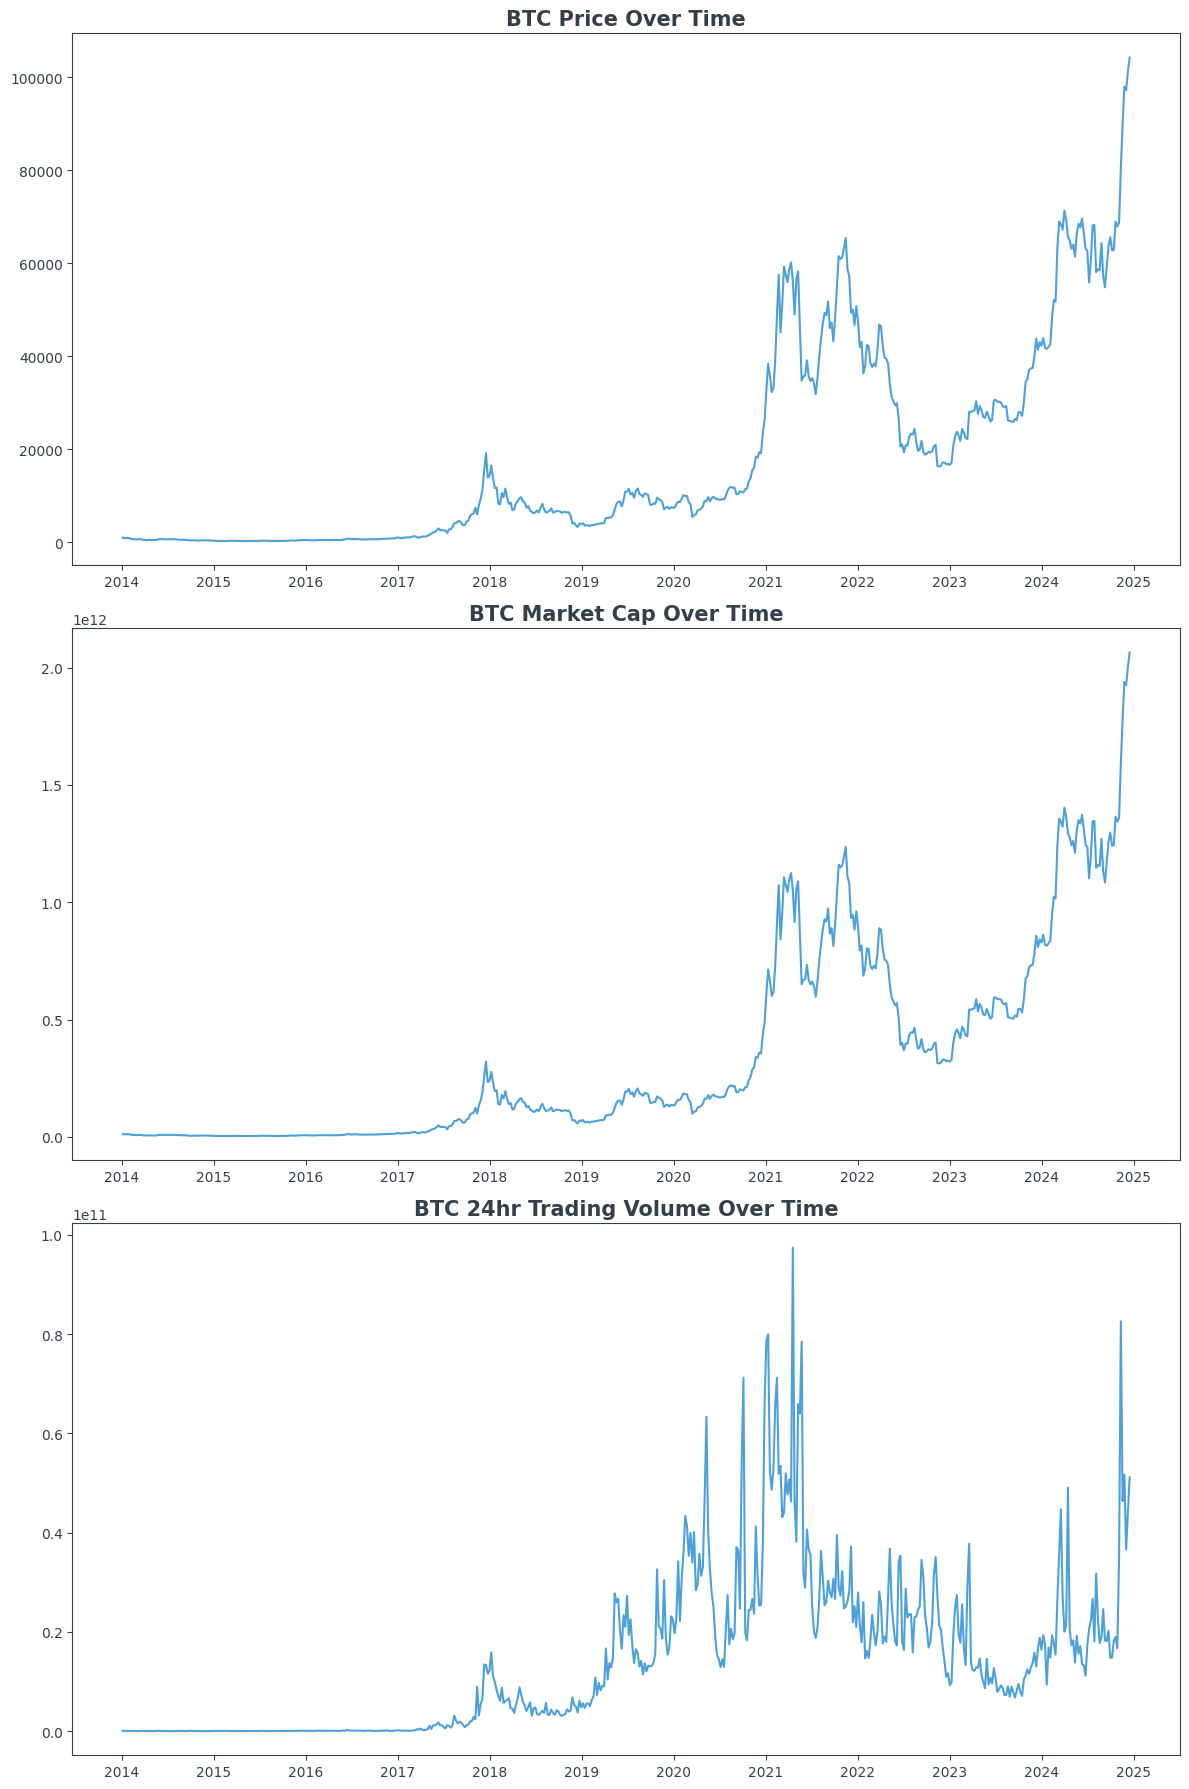


Performing correlation analysis...


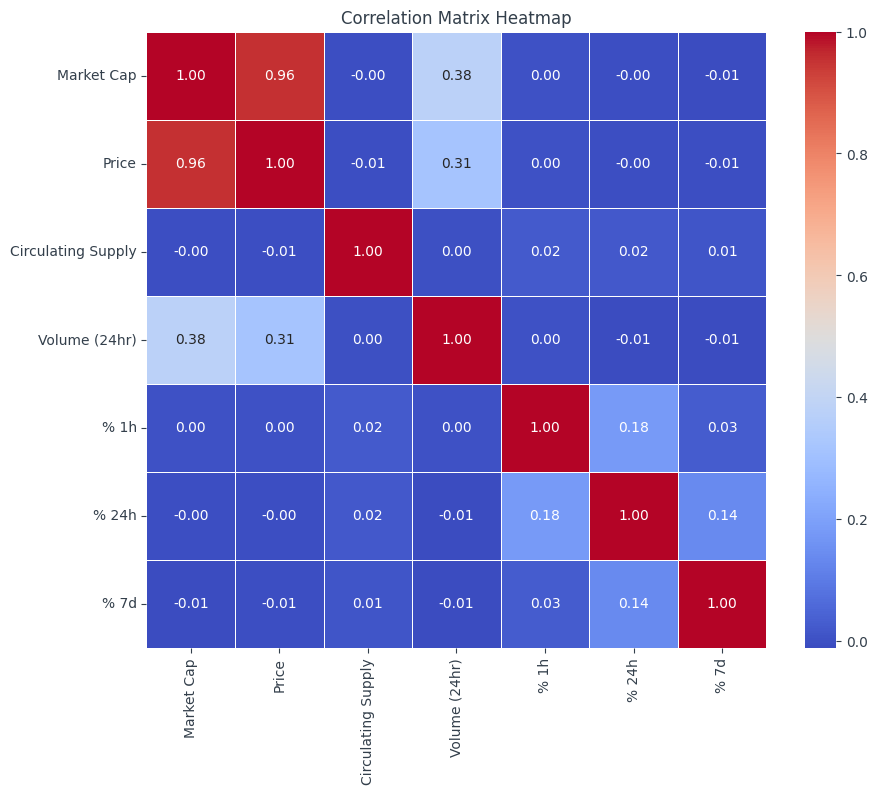


Correlation Matrix:
                    Market Cap     Price  Circulating Supply  Volume (24hr)  \
Market Cap            1.000000  0.956132           -0.004849       0.378328   
Price                 0.956132  1.000000           -0.005462       0.314783   
Circulating Supply   -0.004849 -0.005462            1.000000       0.000396   
Volume (24hr)         0.378328  0.314783            0.000396       1.000000   
% 1h                  0.003223  0.001499            0.022035       0.001867   
% 24h                -0.004830 -0.003570            0.018963      -0.010965   
% 7d                 -0.007653 -0.005584            0.010709      -0.007428   

                        % 1h     % 24h      % 7d  
Market Cap          0.003223 -0.004830 -0.007653  
Price               0.001499 -0.003570 -0.005584  
Circulating Supply  0.022035  0.018963  0.010709  
Volume (24hr)       0.001867 -0.010965 -0.007428  
% 1h                1.000000  0.179235  0.027187  
% 24h               0.179235  1.000000  

<ipython-input-4-dbb9e5dec6b6>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_rates = data_sorted.groupby('Name').apply(
<ipython-input-4-dbb9e5dec6b6>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-4-dbb9e5dec6b6>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-4-dbb9e5dec6b6>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

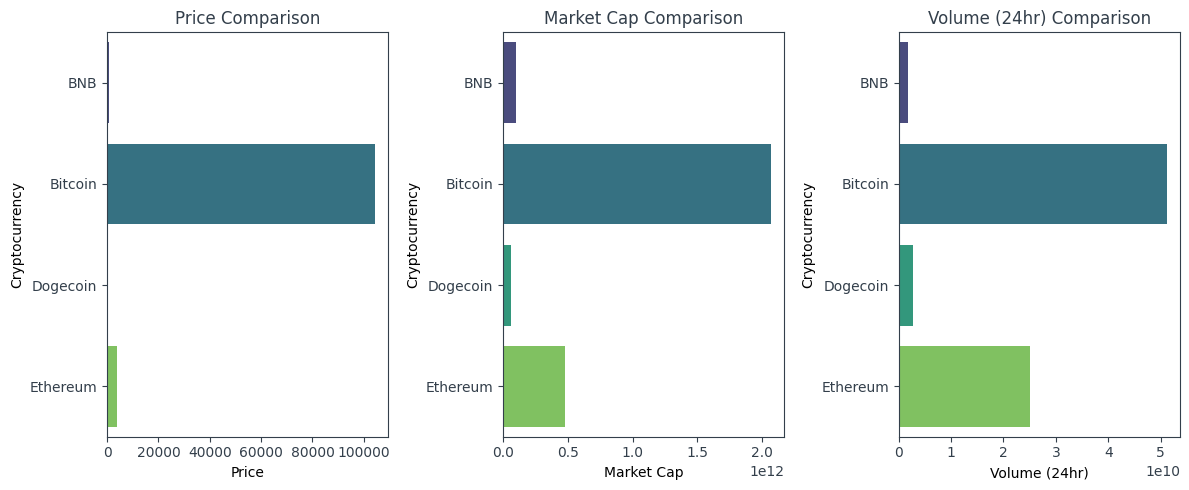


Comparative Data:
                Price    Market Cap  Volume (24hr)
Name                                              
BNB          719.1300  1.035613e+11   1.831104e+09
Bitcoin   104298.7000  2.064764e+12   5.114591e+10
Dogecoin       0.4063  5.981016e+10   2.654366e+09
Ethereum    3951.9400  4.760054e+11   2.506962e+10


In [ ]:
if __name__=="__main__":
    try:
        loader = DataLoader("output_f.csv")
        df = loader.load_data()

        analyzer = DataAnalysis(df)

        print("Performing time series analysis for Bitcoin...")
        analyzer.time_series_analysis('BTC')

        print("\nPerforming correlation analysis...")
        correlation_matrix = analyzer.correlation_analysis()
        print("\nCorrelation Matrix:")
        print(correlation_matrix)

        print("\nPerforming trend analysis...")
        growth_rates = analyzer.trend_analysis()
        print("\nGrowth Rates:")
        print(growth_rates)

        print("\nPerforming volatility analysis...")
        volatility = analyzer.volatility_analysis()
        print("\nVolatility by Cryptocurrency:")
        print(volatility)

        print("\nPerforming comparative analysis...")
        comparative_data = analyzer.comparative_analysis(['Bitcoin', 'Ethereum', 'BNB', 'Dogecoin'])
        print("\nComparative Data:")
        print(comparative_data)

    except FileNotFoundError:
        print("Error: Data file not found. Please ensure the data file exists and the path is correct.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


1. Loading and preparing data...

2. Preprocessing data...

3. Training and evaluating models...

Testing ARIMA model...
Entraînement du modèle ARIMA...

Résumé des paramètres ARIMA:
Order (p,d,q): (5, 1, 0)

Métriques pour le modèle ARIMA:
R² Score: 0.9828
MSE: 0.0007
RMSE: 0.0272

Making predictions with ARIMA...

Visualizing predictions for ARIMA...


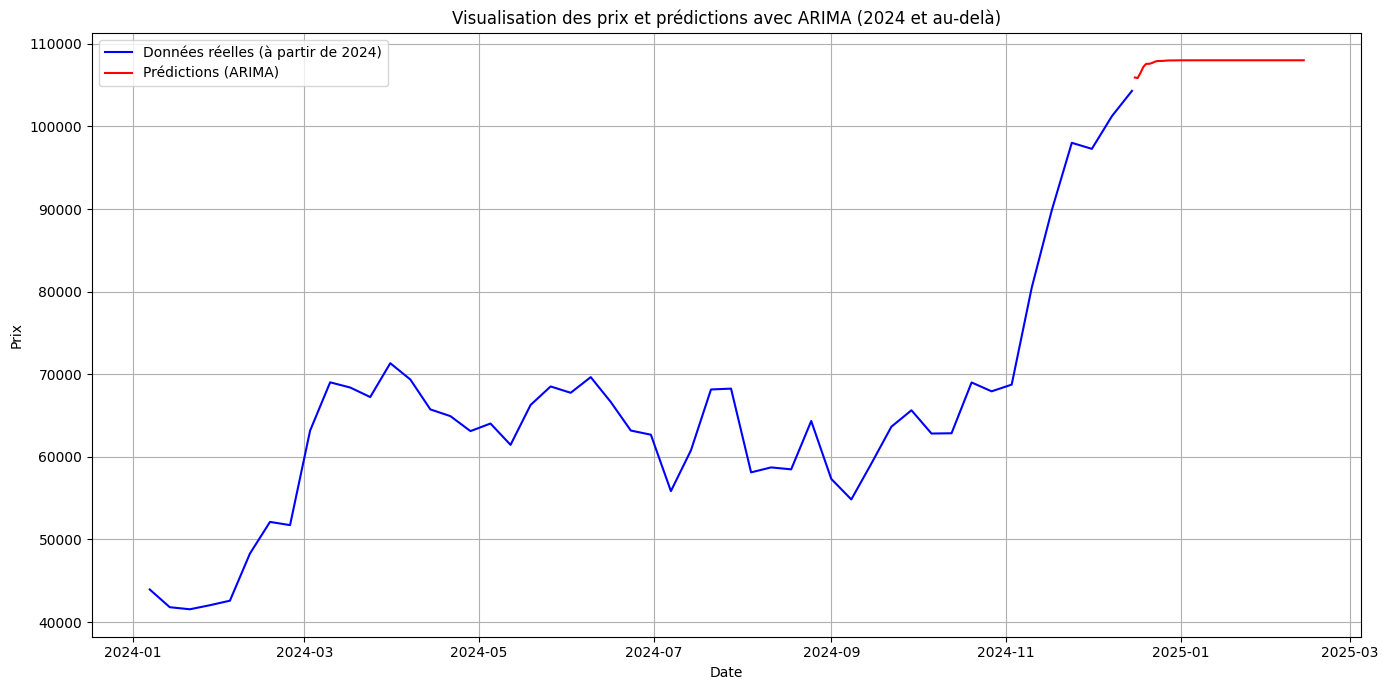


Testing GradientBoosting model...

Métriques pour le modèle GradientBoosting:
R² Score: 0.9902
MSE: 0.0004
RMSE: 0.0200

Making predictions with GradientBoosting...

Visualizing predictions for GradientBoosting...


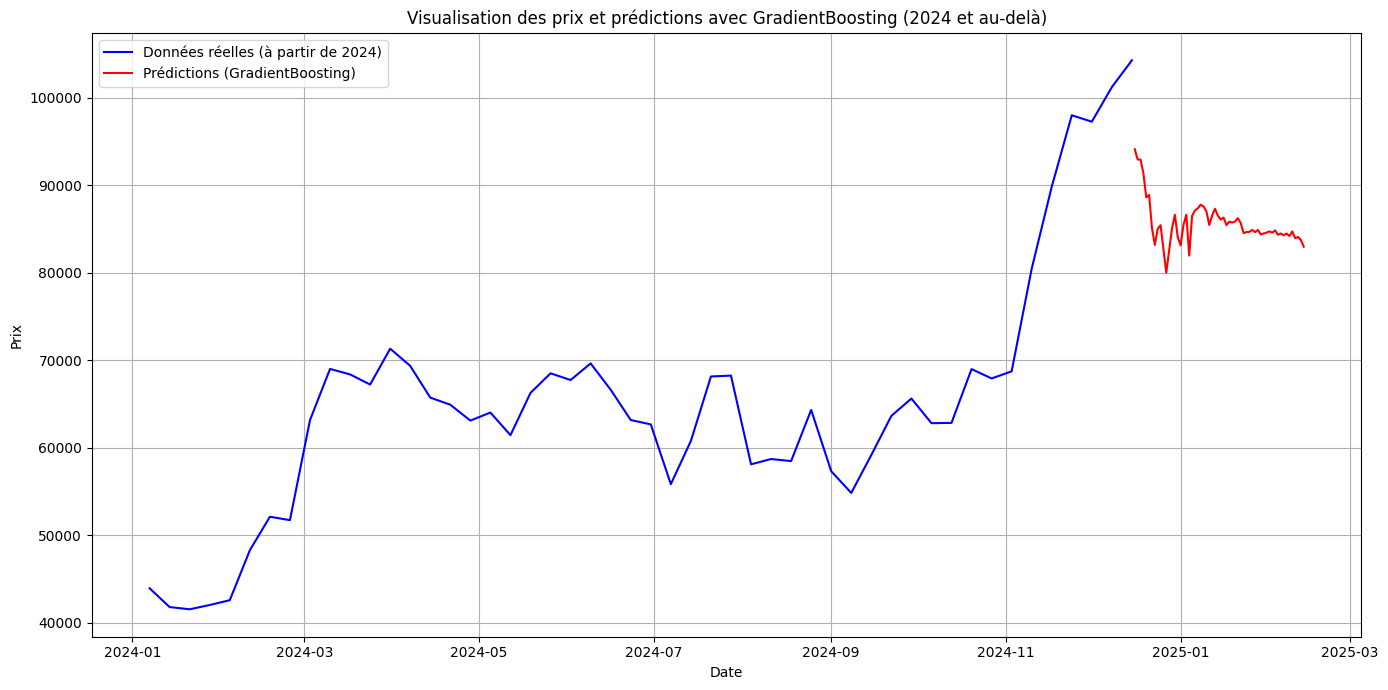


Testing RandomForest model...

Métriques pour le modèle RandomForest:
R² Score: 0.9886
MSE: 0.0005
RMSE: 0.0216

Making predictions with RandomForest...

Visualizing predictions for RandomForest...


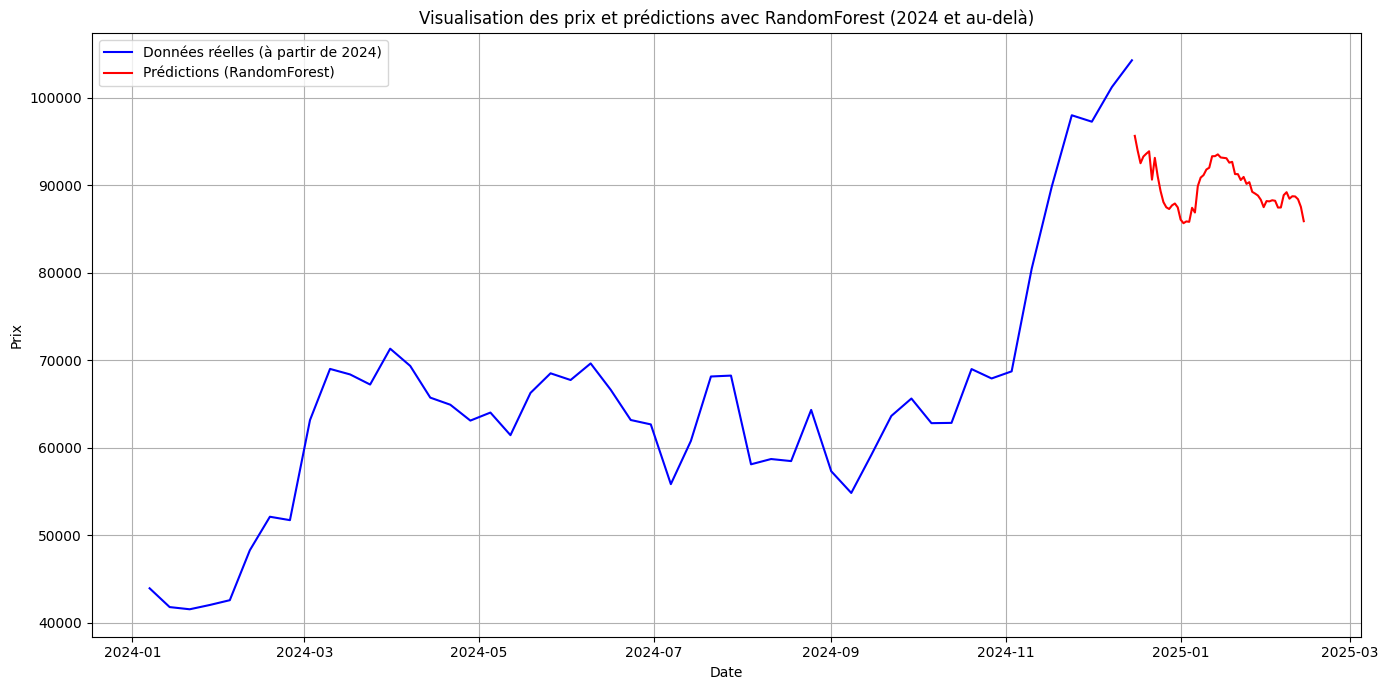


Testing SVR model...

Métriques pour le modèle SVR:
R² Score: 0.8605
MSE: 0.0057
RMSE: 0.0756

Making predictions with SVR...

Visualizing predictions for SVR...


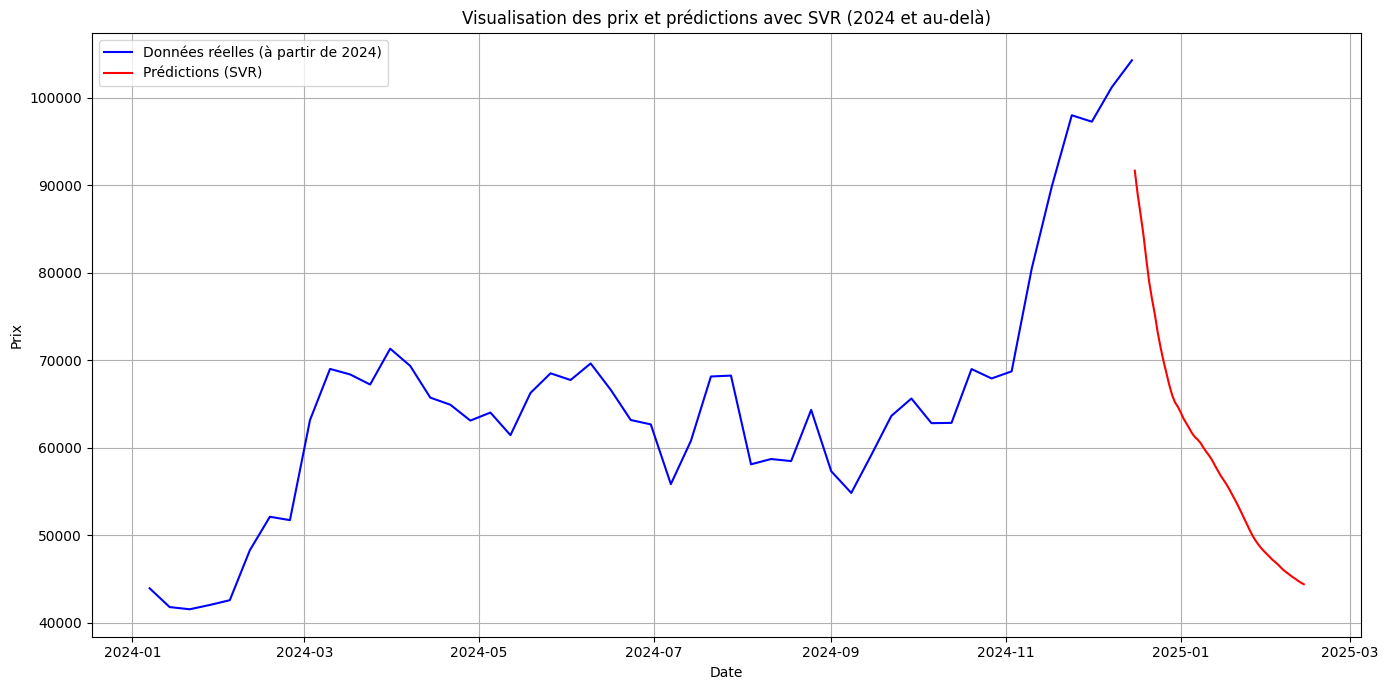


=== Final Results ===
Best performing model: GradientBoosting
Best MSE score: 0.0004
Best RMSE score: 0.0200


In [ ]:
if __name__ == "__main__":
    print("\n1. Loading and preparing data...")
    loader = DataLoader("output_f.csv")
    data_sorted = loader.load_data()

    print("\n2. Preprocessing data...")
    n_steps = 200
    preprocessor = DataPreprocessor(data_sorted, n_steps=n_steps)
    bitcoin_data, X, y, scaler = preprocessor.preprocess()

    print("\n3. Training and evaluating models...")

    models_to_test = [
        ("ARIMA", (5, 1, 0)),
        ("GradientBoosting", None),
        ("RandomForest", None),
        ("SVR", None)
    ]

    best_model = None
    best_mse = float('inf')
    best_model_type = None
    best_predictions = None

    for model_type, arima_params in models_to_test:
        print(f"\nTesting {model_type} model...")

        try:
            trainer = ModelTrainer(
                X,
                y,
                model_type=model_type,
                arima_order=arima_params if arima_params else (5, 1, 0)
            )
            model = trainer.train()

            if trainer.mse_score < best_mse:
                best_mse = trainer.mse_score
                best_model = model
                best_model_type = model_type

            print(f"\nMaking predictions with {model_type}...")
            forecasting = Forecasting(model, scaler, n_steps=n_steps, model_type=model_type)
            price_data_normalized = scaler.transform(bitcoin_data['Price'].values.reshape(-1, 1))
            predictions = forecasting.predict_next_days(price_data_normalized, days=60)

            start_date = bitcoin_data['Date'].iloc[-1]
            future_dates = [start_date + timedelta(days=i) for i in range(1, 61)]

            print(f"\nVisualizing predictions for {model_type}...")
            Visualization.plot(bitcoin_data, predictions, future_dates, model_type=model_type)

        except Exception as e:
            print(f"Error with {model_type} model: {str(e)}")
            continue

    print("\n=== Final Results ===")
    print(f"Best performing model: {best_model_type}")
    print(f"Best MSE score: {best_mse:.4f}")
    print(f"Best RMSE score: {np.sqrt(best_mse):.4f}")